# Estratégias de Treino

Neste script vamos conhecer as principais estratégias de treino e utilização de redes neurais convolucionais:
* Treino do zero (*from scratch*)
* **Extração de Características**
* ***Fine-Tuning* (ajuste fino)**

Mas antes de tudo, vamos fazer os imports.

In [1]:
import os

# Ajuste automático dos workers para aproveitar a CPU sem saturar o sistema operacional.
N_LOGICAL = os.cpu_count() or 8

# Helpers para ler variáveis de ambiente com fallback seguro.
def _env_int(var, default):
    try:
        return int(os.environ.get(var, default))
    except (TypeError, ValueError):
        return default

# Reservamos apenas 1 core para o SO/Jupyter por padrão, mas é configurável via DL_RESERVED_CORES.
RESERVED_MAIN = _env_int('DL_RESERVED_CORES', 1)
AVAILABLE = max(1, N_LOGICAL - RESERVED_MAIN)

# Defaults pensados para manter 8 loaders de treino e 3 de teste em máquinas com 16 vCPUs.
DEFAULT_WORKERS_TRAIN = min(8, max(2, AVAILABLE - 6))
DEFAULT_WORKERS_TEST  = min(4, max(1, AVAILABLE // 4))

N_WORKERS_TRAIN = max(0, _env_int('DL_NUM_WORKERS_TRAIN', DEFAULT_WORKERS_TRAIN))
N_WORKERS_TEST  = max(0, _env_int('DL_NUM_WORKERS_TEST', DEFAULT_WORKERS_TEST))
LOADERS = N_WORKERS_TRAIN + N_WORKERS_TEST

# Mantemos o bloco de computação com a maior parte dos núcleos.
INTRA_DEFAULT = max(4, AVAILABLE - max(1, LOADERS // 4))
INTRA = max(1, _env_int('DL_INTRA_THREADS', INTRA_DEFAULT))

# Controle de prefetch e reuso de workers via variáveis de ambiente (com defaults agressivos para CPU).
PREFETCH_TRAIN = max(2, _env_int('DL_PREFETCH_TRAIN', 6))
PREFETCH_TEST  = max(2, _env_int('DL_PREFETCH_TEST', 4))
PERSISTENT_WORKERS = bool(_env_int('DL_PERSISTENT_WORKERS', 0))

# Afeta NumPy/OpenBLAS/MKL (precisa vir ANTES dos imports de numpy/torch)
os.environ['OMP_NUM_THREADS']      = str(INTRA)
os.environ['MKL_NUM_THREADS']      = str(INTRA)
os.environ['OPENBLAS_NUM_THREADS'] = str(INTRA)

# --- Imprime todas as variáveis ---
print('--- Configurações de Paralelismo ---')
print(f'N_LOGICAL: {N_LOGICAL}')
print(f'RESERVED_MAIN: {RESERVED_MAIN}')
print(f'AVAILABLE: {AVAILABLE}')
print(f'N_WORKERS_TRAIN: {N_WORKERS_TRAIN} (DEFAULT {DEFAULT_WORKERS_TRAIN})')
print(f'N_WORKERS_TEST: {N_WORKERS_TEST} (DEFAULT {DEFAULT_WORKERS_TEST})')
print(f'LOADERS (train+test): {LOADERS}')
print(f'INTRA threads: {INTRA}')
print(f'PREFETCH_TRAIN: {PREFETCH_TRAIN}')
print(f'PREFETCH_TEST: {PREFETCH_TEST}')
print(f'PERSISTENT_WORKERS: {PERSISTENT_WORKERS}')
print('------------------------------------')
print('Variáveis de ambiente definidas:')
print(f"  OMP_NUM_THREADS: {os.environ.get('OMP_NUM_THREADS')}")
print(f"  MKL_NUM_THREADS: {os.environ.get('MKL_NUM_THREADS')}")
print(f"  OPENBLAS_NUM_THREADS: {os.environ.get('OPENBLAS_NUM_THREADS')}")
print('------------------------------------')



--- Configurações de Paralelismo ---
N_LOGICAL: 16
RESERVED_MAIN: 1
AVAILABLE: 15
N_WORKERS_TRAIN: 8 (DEFAULT 8)
N_WORKERS_TEST: 3 (DEFAULT 3)
LOADERS (train+test): 11
INTRA threads: 13
PREFETCH_TRAIN: 6
PREFETCH_TEST: 4
PERSISTENT_WORKERS: False
------------------------------------
Variáveis de ambiente definidas:
  OMP_NUM_THREADS: 13
  MKL_NUM_THREADS: 13
  OPENBLAS_NUM_THREADS: 13
------------------------------------


In [2]:
# Importa NumPy para controle de aleatoriedade em operações numéricas.
import numpy as np

# Importa o núcleo do PyTorch (tensores, computação em CPU/GPU).
import torch

# Afeta kernels do PyTorch
torch.set_num_threads(INTRA)
# Interop menor ajuda a manter as threads livres para o dataloader.
torch.set_num_interop_threads(max(1, min(4, INTRA // 3)))


In [3]:
# Título/seção do bloco: implementação e treinamento de uma rede neural.
# Implementação e treinamento da rede

# Importa módulos do SO e gerador pseudoaleatório padrão do Python.
import random
from tqdm.auto import tqdm

# Importa utilitário de cópia profunda.
import copy
import contextlib

# Define um valor de semente único a ser usado por todas as bibliotecas.
SEED = 42

# Fixa a semente do gerador aleatório do Python (random).
random.seed(SEED)

# Fixa a semente do NumPy.
np.random.seed(SEED)

# Fixa a semente do PyTorch na CPU.
torch.manual_seed(SEED)

# Importa submódulos de redes neurais e otimizadores do PyTorch.
from torch import nn, optim

# Título/seção informativa: carregamento de dados e modelos prontos.
# Carregamento de Dados e Modelos
# Importa utilitário para criação de DataLoaders (mini-batches, shuffle, workers).
from torch.utils.data import DataLoader
# Importa coleções de datasets e modelos (pré-treinados) do torchvision.
from torchvision import datasets, models
# Importa transforms para pré-processamento/augmentação das imagens.
from torchvision import transforms

# Título/seção informativa: ferramentas para métricas e visualização.
# Plots e análises
# Importa função de acurácia do scikit-learn.
from sklearn.metrics import accuracy_score
# Importa Matplotlib para gráficos.
import matplotlib.pyplot as plt
# Importa NumPy para operações numéricas.
import numpy as np
# Importa utilitários de tempo e sistema (medir época, checar caminhos/variáveis).
import time, os
# Operações funcionais do PyTorch (AdaptiveAvgPool2d, etc.).
import torch.nn.functional as F

# (Jupyter) Garante que os gráficos do Matplotlib apareçam embutidos nas células.
get_ipython().run_line_magic('matplotlib', 'inline')

# Comentário: dicionário de hiperparâmetros da rotina de treino.
# Configurando hiperparâmetros.
# Cria um dicionário com número de épocas, learning rate, weight decay e tamanho de batch.
args = {
# Define o número de épocas de treinamento.
    'epoch_num': 5,      # Número de épocas.
# Define a taxa de aprendizado (learning rate) do otimizador.
    'lr': 1e-3,           # Taxa de aprendizado.
# Define penalização L2 (regularização) aplicada aos pesos.
    'weight_decay': 8e-4, # Penalidade L2 (Regularização).
# Define o tamanho do mini-batch usado no DataLoader/treino.
    'batch_size': 64,     # Tamanho do batch na CPU.
# Fecha o dicionário de hiperparâmetros.
}

# Ajustes específicos para CPU.
PIN_MEMORY = False
USE_CHANNELS_LAST = True
USE_BF16 = bool(_env_int('DL_USE_BF16', 0))

print('Treinando apenas na CPU')
print(f'USE_BF16 (cpu autocast): {USE_BF16}')


Treinando apenas na CPU
USE_BF16 (cpu autocast): False


# Extração de características

Esta estratégia tem como base o uso de modelos **pré-treinados** em datasets de larga escala. Redes treinadas em uma quantidade significativa e bem diversa de dados são capazes de extrair características de altíssima qualidade em dados que nunca viram antes.

Como apresentado na imagem, a extração é realizada da seguinte forma:
* **Adapta-se a rede**: A camada de classificação é removida da rede pré-treinada. 
* **Extrai as características**: Realiza o forward dos dados na rede. A última camada agora não realiza classificação, apenas produz características de alto nível semântico.
* **Treina um classificador comum**: Alimenta as características extraídas dos dados de treino e de teste a um classificador (como o SVM).

<img src="Drawing.png" alt="drawing" width="650"/>

## Carregando Dados

Nesse script usaremos um modelo pré-treinado no **[ImageNet](http://www.image-net.org/)**, um dataset com 1.000 classes de objeto. Até os dias de hoje, modelos pré-treinados nesse conjunto de dados produzem características que servem como base para inúmeras aplicações.

O carregamento de dados deve seguir **o mesmo pré-processamento** do treinamento do modelo utilizado. <br>
Pré-processamento com base no ImageNet: https://github.com/pytorch/examples/blob/master/imagenet/main.py#L202

Usaremos uma **[composição de transformações](https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision.transforms.Compose)** do PyTorch para realizar múltiplas transformações no dado.

```python
transforms.Compose([
     # Lista de transformações.
])
```

In [4]:
# Cria um pipeline de transformações para pré-processar imagens antes de entregá-las ao modelo.
data_transform = transforms.Compose([
# Redimensiona a imagem para 224 px no lado menor (tamanho comum a modelos como ResNet/VGG).
                                     transforms.Resize(224),
# Converte PIL/NumPy → Tensor (C×H×W) com valores em [0,1].
                                     transforms.ToTensor(),
# Normaliza por canal usando médias e desvios padrão do ImageNet (melhora convergência ao usar modelos pré-treinados).
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                          std=[0.229, 0.224, 0.225])
# Fecha a lista do Compose.
                  ])

# Instancia o conjunto de TREINO do CIFAR-10 no diretório atual, aplicando o pipeline de transformações.
train_set = datasets.CIFAR10('.', 
# Define que é o split de treino.
                      train=True, 
# Aplica a transformação composta definida acima a cada amostra.
                      transform= data_transform, # transformação composta 
# Faz download se não existir localmente.
                      download=True)

# Instancia o conjunto de TESTE do CIFAR-10 no diretório atual, com as mesmas transformações.
test_set = datasets.CIFAR10('.', 
# Define que é o split de teste/validação.
                      train=False, 
# Usa o mesmo pipeline para manter pré-processamento consistente entre treino e teste.
                      transform= data_transform, # transformação composta 
# Aqui não força download novamente; assume que já foi baixado no passo do treino.
                      download=False)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8952821..2.5877128].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5005665].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0494049..2.5877128].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.4842881..2.2739873].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9980307..1.8158263].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9656862..1.4954191].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793

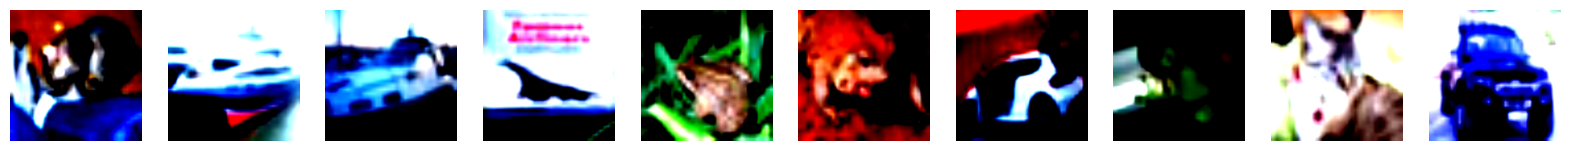

In [5]:
# Cria uma figura com 1 linha e 10 eixos (subplots); figsize define o tamanho total em polegadas.
fig, axs = plt.subplots(1,10, figsize=(20, 2))

# Itera sobre os 10 primeiros exemplos do conjunto de teste.
for i in range(10):
  # Obtém a imagem (tensor) e o rótulo (int) no índice i.
  data, label = test_set[i]
  # Exibe a imagem no eixo i; permuta de C×H×W → H×W×C para o Matplotlib.
  # OBS: como o dataset foi normalizado (ImageNet mean/std), as cores podem ficar “estranhas” sem dessormalizar.
  axs[i].imshow(data.permute((1,2,0)))
  # Remove eixos/grades para uma visualização limpa.
  axs[i].axis('off')


In [6]:
g = torch.Generator().manual_seed(SEED)

# Define a função de inicialização dos workers do DataLoader (executa em cada processo/worker).
def _worker_init_fn(_):
    # Cria uma semente por worker a partir da semente global do PyTorch (reduzida para 32 bits).
    seed = torch.initial_seed() % (2**32)
    # Inicializa o gerador pseudoaleatório padrão do Python com a semente do worker.
    random.seed(seed)
    # Inicializa o gerador do NumPy com a mesma semente (reprodutibilidade por worker).
    np.random.seed(seed)

    # Limita o número de threads usadas por bibliotecas baseadas em OpenMP (evita contensão com o treino).
    os.environ["OMP_NUM_THREADS"] = "1"
    # Limita o número de threads do backend MKL (NumPy/SciPy compilados com MKL).
    os.environ["MKL_NUM_THREADS"] = "1"
    # Limita o número de threads do OpenBLAS.
    os.environ["OPENBLAS_NUM_THREADS"] = "1"
    # Tenta também limitar as threads internas do PyTorch dentro do worker.
    try:
        # Define 1 thread para operações intra-op (dentro de uma única operação).
        torch.set_num_threads(1)
        # Define 1 thread para paralelismo inter-op (entre operações).
        torch.set_num_interop_threads(1)
    # Se a API não existir/estiver indisponível, ignora silenciosamente.
    except Exception:
        pass


In [7]:
# Cria o DataLoader de TREINO com configurações de performance para CPU.
train_loader = DataLoader(
    # Dataset de treino previamente instanciado.
    train_set,
    # Tamanho do mini-batch; definido em args (menor no CPU).
    batch_size=args['batch_size'],
    # Embaralha amostras a cada época (boa prática no treino).
    shuffle=True,
    # Quantidade de processos workers para carregar dados em paralelo.
    num_workers=N_WORKERS_TRAIN,
    # Pinned memory só faz diferença para GPU; no CPU fica False automaticamente.
    pin_memory=PIN_MEMORY,
    # Descarta o último lote se ele for menor que batch_size (estabiliza shapes).
    drop_last=True,
    # Função de init para cada worker (limita threads internas) apenas se houver workers.
    worker_init_fn=_worker_init_fn if N_WORKERS_TRAIN > 0 else None,
    generator=g,
    # Prefetch agressivo para manter a fila cheia quando há múltiplos workers.
    prefetch_factor=PREFETCH_TRAIN if N_WORKERS_TRAIN > 0 else 2,
    # Mantém workers vivos apenas se explicitamente solicitado.
    persistent_workers=PERSISTENT_WORKERS and (N_WORKERS_TRAIN > 0),
)

# Cria o DataLoader de TESTE/validação (sem embaralhar e com menos workers).
test_loader = DataLoader(
    test_set,
    batch_size=args['batch_size'],
    shuffle=False,
    num_workers=N_WORKERS_TEST,
    pin_memory=PIN_MEMORY,
    worker_init_fn=_worker_init_fn if N_WORKERS_TEST > 0 else None,
    generator=g,
    prefetch_factor=PREFETCH_TEST if N_WORKERS_TEST > 0 else 2,
    persistent_workers=PERSISTENT_WORKERS and (N_WORKERS_TEST > 0),
)


## Adaptando a rede

Vamos escolher um modelo da biblioteca de modelos pré-treinados do PyTorch:<br>
https://pytorch.org/docs/stable/torchvision/models.html

Infelizmente o PyTorch não inclui um modelo pré-treinado da LeNet que implementamos anteriormente. Usaremos então um dos modelos modernos de CNN.

In [8]:
# Carrega a VGG16 com BatchNorm pré-treinada no ImageNet diretamente na CPU.
net = models.vgg16_bn(weights=models.VGG16_BN_Weights.IMAGENET1K_V1)
if USE_CHANNELS_LAST:
    net = net.to(memory_format=torch.channels_last)

# Imprime a arquitetura completa (camadas e parâmetros) para inspeção.
print(net)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

Através da função ```net.children()``` conseguimos acessar individualmente os módulos implementados na rede. 

https://pytorch.org/docs/stable/nn.html#torch.nn.Module.children

In [9]:
# Imprime o último filho nomeado do modelo (tupla (nome, módulo)); na VGG16_BN costuma ser ('classifier', Sequential(...)).
print(list(net.named_children())[-1])

('classifier', Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
))


Podemos redefinir a rede com todos os módulos originais **exceto o último**, responsável pela classificação das características aprendidas pelas camadas anteriores.

In [10]:
# Substitui o 'classifier' da VGG16 por uma versão encurtada (remove as 3 últimas camadas) e mantém tudo na CPU.
net.classifier = nn.Sequential(*list(net.classifier.children())[:-3])
if USE_CHANNELS_LAST:
    net = net.to(memory_format=torch.channels_last)

# Exibe a arquitetura atualizada para conferir a troca do 'classifier'.
print(net)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

## Extraindo

Nesse passo realizamos o mesmo fluxo da função de validação que implementamos anteriormente. Dessa vez não precisamos calcular a predição final, apenas armazenar as saídas da rede.

In [11]:
# Coloca o modelo no layout de memória channels_last (melhora desempenho em CPU/oneDNN).
if USE_CHANNELS_LAST:
    net = net.to(memory_format=torch.channels_last)

# Função auxiliar: extrai só as features convolucionais/avgpool da VGG e achata.
def forward_features_vgg(m, x):
    # Passa apenas pelo extrator convolucional (m.features).
    x = m.features(x)
    # Usa um GAP 1x1 para reduzir drasticamente a dimensionalidade.
    x = F.adaptive_avg_pool2d(x, (1, 1))
    # Achata em (batch, D) preservando a dimensão do batch.
    return torch.flatten(x, 1)

# Extrai características e rótulos de um loader; opções para layout, fonte das features e BF16.
def extrai_caracteristicas(net, loader, desc="Extract", use_channels_last=True, use_conv_feats=False, use_bf16=False):
    # Coloca a rede em modo de avaliação (desativa dropout/usa BN em eval).
    net.eval()

    # Número total de amostras do dataset por trás do loader.
    N = len(loader.dataset)
    # Buffer de features (alocado no 1º batch quando soubermos D).
    X = None
    # Pré-aloca os rótulos no CPU (tipo long) para N amostras.
    Y = torch.empty(N, dtype=torch.long)
    # Índice de escrita no buffer (offset).
    i = 0

    feats_fn = (lambda z: forward_features_vgg(net, z)) if use_conv_feats else (lambda z: net(z))

    # Define contexto opcional para autocast BF16 no CPU (quando suportado).
    autocast_ctx = contextlib.nullcontext()
    if use_bf16 and hasattr(torch, 'amp') and hasattr(torch.amp, 'autocast'):
        autocast_ctx = torch.amp.autocast('cpu', dtype=torch.bfloat16)
        use_channels_last = True  # oneDNN + BF16 funcionam melhor juntos
    elif use_bf16 and hasattr(torch, 'cpu') and hasattr(torch.cpu, 'amp'):
        # Fallback para versões antigas do PyTorch
        autocast_ctx = torch.cpu.amp.autocast(dtype=torch.bfloat16)
        use_channels_last = True
    else:
        use_bf16 = False  # registro para logs externos

    with torch.inference_mode():
        with autocast_ctx:
            pbar = tqdm(loader, total=len(loader),
                        desc=desc, mininterval=0.5, smoothing=0.05,
                        leave=False, dynamic_ncols=True)

            # Itera por lotes (dado, rotulo) do loader.
            for dado, rotulo in pbar:
                # Tamanho do batch atual.
                b = rotulo.size(0)

                if use_channels_last:
                    dado = dado.contiguous(memory_format=torch.channels_last)

                # Extrai features com a função selecionada (pode ser conv-feats ou saída da rede).
                feats = feats_fn(dado)
                # Garante tensor 2D (b, D) achatando o restante e mantido na CPU.
                feats = feats.reshape(b, -1).to(torch.float32)

                # No primeiro batch, aloca X inteiro de uma só vez com shape (N, D).
                if X is None:
                    D = feats.size(1)
                    X = torch.empty((N, D), dtype=feats.dtype)

                # Copia o bloco de features para a fatia correspondente.
                X[i:i+b] = feats
                Y[i:i+b] = rotulo
                # Avança o índice global pelo tamanho do batch.
                i += b

    # Converte buffers para NumPy uma única vez e retorna (features, rótulos).
    return X.numpy(), Y.numpy()


In [12]:
# Marca o início para medir o tempo da extração de treino.
start = time.time()

# Informa no console que a extração de características do conjunto de treino vai começar.
print('Load train')

# Extrai as características (train_X) e os rótulos (train_Y) passando a rede e o DataLoader de treino.
train_X, train_Y = extrai_caracteristicas(
    net,
    train_loader,
    use_channels_last=USE_CHANNELS_LAST,
    use_conv_feats=True,
    use_bf16=USE_BF16,
)

# Marca o fim para computar a duração da extração de treino.
end = time.time()
# Imprime o tempo.
print('\n')
print('Time: %.2f' % (end-start))
  
# Marca o início para medir o tempo da extração de teste.
start = time.time()

# Pula uma linha e indica o início da extração no conjunto de teste/validação.
print('\nLoad test')

# Extrai as características (test_X) e rótulos (test_Y) usando o DataLoader de teste.
test_X,  test_Y  = extrai_caracteristicas(
    net,
    test_loader,
    use_channels_last=USE_CHANNELS_LAST,
    use_conv_feats=True,
    use_bf16=USE_BF16,
)

# Marca o fim para computar a duração da extração de teste.
end = time.time()
# Imprime o tempo.
print('\n')
print('Time: %.2f' % (end-start))


Load train


Extract:   0%|          | 0/781 [00:00<?, ?it/s]



Time: 1814.11

Load test


Extract:   0%|          | 0/157 [00:00<?, ?it/s]



Time: 378.05


### Treinando um modelo de classificação (SVM)
Documentação: https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html

Modelos de classificação no pacote ```scikit-learn``` seguem o seguinte padrão de uso:
```python
# Definição do classificador
clf = LinearSVC()
#Treinando 
clf.fit(X, y)
# Usando no teste
pred = clf.predict(Xt)
```

In [13]:
# Importa o classificador SVM linear (margem máxima com perda hinge) do scikit-learn.
from sklearn.svm import LinearSVC

# Instancia um SVM linear configurado para datasets densos e de alta dimensionalidade.
# (Se aparecer aviso de convergência, aumente max_iter ou ajuste C.)
clf = LinearSVC(dual=False, max_iter=3000, tol=1e-3, verbose=1)

# Marca o início para medir o tempo de treino.
start = time.time()

# Treina o classificador nas características extraídas (X) e rótulos (y) do conjunto de treino.
clf.fit(train_X, train_Y)

# Gera predições para o conjunto de teste a partir das características extraídas.
pred = clf.predict(test_X)

# Calcula a acurácia.
acc = accuracy_score(test_Y, pred)

# Marca o fim para computar a duração d0 treino.
end = time.time()
# Imprime  a acurácia % e tempo com duas casas decimais.

print('\n')
print('Acc: %.2f, Time: %.2f' % (acc*100, end-start))


[LibLinear]iter  1 act 4.914e+04 pre 4.865e+04 delta 3.675e-01 f 5.000e+04 |g| 2.675e+05 CG   1
iter  2 act 5.797e+02 pre 4.684e+02 delta 3.675e-01 f 8.611e+02 |g| 1.719e+04 CG   1
iter  3 act 1.745e+02 pre 1.400e+02 delta 3.675e-01 f 2.813e+02 |g| 5.858e+03 CG   1
iter  4 act 5.869e+01 pre 4.643e+01 delta 3.675e-01 f 1.068e+02 |g| 2.059e+03 CG   1
cg reaches trust region boundary
iter  5 act 3.811e+01 pre 3.561e+01 delta 4.419e-01 f 4.814e+01 |g| 7.631e+02 CG   3
iter  6 act 4.549e+00 pre 5.347e+00 delta 4.419e-01 f 1.003e+01 |g| 1.734e+02 CG   4
iter  7 act 8.924e-01 pre 7.207e-01 delta 4.419e-01 f 5.478e+00 |g| 2.636e+02 CG   1
iter  8 act 2.603e-01 pre 2.093e-01 delta 4.419e-01 f 4.586e+00 |g| 8.931e+01 CG   1
iter  9 act 8.105e-02 pre 6.536e-02 delta 4.419e-01 f 4.326e+00 |g| 3.087e+01 CG   1
iter 10 act 9.215e-02 pre 8.834e-02 delta 4.419e-01 f 4.245e+00 |g| 1.075e+01 CG   4
iter 11 act 9.619e-03 pre 1.094e-02 delta 4.419e-01 f 4.152e+00 |g| 2.765e+00 CG   4
iter 12 act 2.392e-03



---


# Fine-Tuning

O objetivo aqui é aproveitar o valor de um modelo bem treinado e sua capacidade de generalizar pra dados que nunca viu antes.
 
Lembre-se que o aprendizado é hierárquico, ou seja, camadas iniciais (em vermelho na imagem) aprendem características de baixo nível (bordas, quinas, etc.) que podem ser aproveitadas para múltiplos datasets. **Adaptamos então camadas mais semânticas** (em amarelo na imagem), que aprendem características mais específicas do dataset de treino. 

Aqui seguiremos dois passos:
* Substituir a camada de classificação da rede original;
* "Congelar" camadas iniciais da rede, para preservar seus pesos;
* Definir múltiplas taxas de aprendizado para treinar as camadas finais.

<img src="Drawing2.png" alt="drawing" width="600"/>

## Adaptando a Rede

In [14]:
# Carrega a VGG16 com BatchNorm pré-treinada (ImageNet) já posicionada na CPU.
net = models.vgg16_bn(weights=models.VGG16_BN_Weights.IMAGENET1K_V1)
if USE_CHANNELS_LAST:
    net = net.to(memory_format=torch.channels_last)

# Imprime toda a arquitetura para inspeção (camadas, shapes e parâmetros).
print(net)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

Dessa vez vamos redefinir a camada de classificação, criando uma nova camada de dimensões adequadas ao nosso desafio.

* O modelo original classificava as 1.000 classes do ImageNet <br>
```nn.Linear(in_features, 1000)```
* Nossa adaptação irá classificar 10 classes do CIFAR10 <br> 
```nn.Linear(in_features, 10)```

In [15]:
# Captura o número de FEATURES (neurônios de entrada) da última camada linear atual da VGG (antes de trocar pelo nosso head).
in_features = list(net.children())[-1][-1].in_features

# Cria uma lista com TODAS as camadas do classifier atual, exceto a última (que era para 1000 classes do ImageNet).
new_classifier = list(net.classifier.children())[:-1]

# Acrescenta uma nova camada Linear mapeando de in_features → 10 classes (CIFAR-10).
new_classifier.append(nn.Linear(in_features, 10))

# Substitui o classifier da VGG por um nn.Sequential com as camadas modificadas.
net.classifier = nn.Sequential(*new_classifier)
if USE_CHANNELS_LAST:
    net = net.to(memory_format=torch.channels_last)

# Imprime o novo classifier para confirmar a arquitetura (última Linear agora com out_features=10).
print(net.classifier)


Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=10, bias=True)
)


## Definindo múltiplas taxas de aprendizado

Para "congelar" as camadas iniciais basta alterar o atributo ```requires_grad```, definindo-o como ```False``` para parâmetros que não queremos treinar. Podemos iterar nos parâmetros da rede através da função ```net.named_parameters()```.

Para definir múltiplas taxas de aprendizados no otimizador, podemos consultar a documentação do pacote ```optim```:<br> 
https://pytorch.org/docs/stable/optim.html

Podemos definir uma lista de dicionários para cada módulo que desejamos treinar.
```python
optim.Adam([
            {'params': model.base.parameters()},
            {'params': model.classifier.parameters(), 'lr': 1e-3}
          ], lr=0)
```

In [16]:
# Cria um otimizador Adam com dois grupos de parâmetros (features e classifier).
optimizer = optim.Adam([

# Grupo 1: parâmetros do extrator de características com LR e weight decay reduzidos (20% dos valores base).
            {'params': net.features.parameters(), 'lr': args['lr'] * 0.2, 'weight_decay': args['weight_decay'] * 0.2},

# Grupo 2: parâmetros do classificador com LR e weight decay nos valores base definidos em args.
            {'params': net.classifier.parameters(), 'lr': args['lr'], 'weight_decay': args['weight_decay']}
# Fecha a lista de grupos; lr=0 aqui é ignorado para esses grupos porque cada um define seu próprio LR.
        ], lr=0)

Não esquece de definir a função de perda :)

In [17]:
# Define a função de perda de entropia cruzada (para classificação multi-classe) diretamente na CPU.
criterion = nn.CrossEntropyLoss()


## Treino e Validação

Aqui usaremos o fluxo idêntico ao que implementamos anteriormente. Já alteramos a rede e o otimizador para indicar que realizaremos um fine-tuning e não um treinamento *from scratch*.

In [18]:
# Define a função de treinamento para uma época; usa `criterion` e `optimizer` já definidos.
def train(train_loader, net, epoch):
    # Coloca o modelo em modo de treino (ativa Dropout / BN em training).
    net.train()

    # Marca o início para medir o tempo da época.
    start = time.time()

    # Lista de perdas (floats) para computar média/desvio ao final.
    losses = []           # guarda floats (loss.item())
    # Contadores de acertos e total de amostras para acurácia on-the-fly.
    correct = 0           # acertos acumulados
    total = 0             # amostras acumuladas

    # Número total de lotes do DataLoader (para logs e barra de progresso).
    total_batches = len(train_loader)
    # Frequência de atualização do log (~2% dos lotes, mas pelo menos a cada 10).
    LOG_EVERY = max(10, total_batches // 50)  # ~2% dos lotes

    # Barra de progresso com tqdm (requer: `from tqdm import tqdm` em algum lugar do código).
    pbar = tqdm(
        train_loader,
        total=total_batches,
        desc=f"Train {epoch}",
        mininterval=0.5,
        smoothing=0.05,
        leave=False,
        dynamic_ncols=True
    )

    # Itera sobre os lotes; `i` começa em 1 para facilitar o módulo com LOG_EVERY.
    for i, (dado, rotulo) in enumerate(pbar, 1):
        # Ajusta layout para channels_last quando configurado.
        if USE_CHANNELS_LAST:
            dado = dado.contiguous(memory_format=torch.channels_last)

        # Forward: calcula os logits previstos pelo modelo.
        ypred = net(dado)
        # Calcula a perda do lote de acordo com o critério (CrossEntropy).
        loss  = criterion(ypred, rotulo)

        # Backprop: zera gradientes (mais eficiente com set_to_none=True).
        optimizer.zero_grad(set_to_none=True)  # menos overhead que zero_grad()
        # Propaga o erro para obter gradientes.
        loss.backward()
        # Atualiza os parâmetros conforme a regra do otimizador.
        optimizer.step()

        # Acumula a perda (como float) para estatísticas do epoch.
        losses.append(loss.item())
        # Converte logits em predição de classe (argmax no eixo das classes).
        pred = ypred.argmax(dim=1)
        # Soma acertos deste lote ao total (comparando com os rótulos verdadeiros).
        correct += (pred == rotulo).sum().item()
        # Incrementa o número total de amostras vistas até aqui.
        total   += rotulo.size(0)

        # Atualiza o texto da barra apenas de tempos em tempos (reduz overhead de UI).
        if (i % LOG_EVERY == 0) or (i == total_batches):
            # Perda média corrente.
            avg_loss = float(np.mean(losses))
            # Acurácia corrente em %.
            acc_now  = 100.0 * correct / max(1, total)
            # Mostra no postfix da barra.
            pbar.set_postfix_str(f"loss={avg_loss:.4f} acc={acc_now:.2f}%")

    # Marca o término para medir a duração total da época.
    end = time.time()

    # Calcula estatísticas agregadas de perda e acurácia da época.
    epoch_loss_mean = float(np.mean(losses))
    epoch_loss_std  = float(np.std(losses))
    acc = 100.0 * correct / max(1, total)

    # Log legível com resumo do desempenho na época.
    print('#################### Train ####################')
    print('Epoch %d, Loss: %.4f +/- %.4f, Acc: %.2f, Time: %.2f' %
          (epoch, epoch_loss_mean, epoch_loss_std, acc, end - start))

    # Retorna a perda média da época (útil para curvas/early stopping).
    return epoch_loss_mean


In [19]:
# Define a função de validação (avalia o modelo sem gradientes por uma época).
def validate(test_loader, net, epoch):
    # Coloca a rede em modo de avaliação (desativa dropout / usa BN com running stats).
    net.eval()
    # Marca o início para medir o tempo gasto.
    start = time.time()

    # Vetor de perdas (floats) para média/desvio no fim.
    losses  = []   # guarda floats (loss.item())
    # Contador de acertos acumulados.
    correct = 0
    # Contador de amostras acumuladas.
    total   = 0

    # Número total de lotes (para tqdm e frequência de log).
    total_batches = len(test_loader)
    # Atualiza logs ~2% dos lotes (mínimo a cada 10) para reduzir overhead da UI.
    LOG_EVERY = max(10, total_batches // 50)  # ~2% dos lotes

    # Desativa autograd e ativa otimizações específicas de inferência (ligeiramente mais rápido que no_grad()).
    with torch.inference_mode():  # ligeiramente mais rápido que no_grad()
        # Cria barra de progresso sobre o test_loader.
        pbar = tqdm(
            # Iterable a ser percorrido (DataLoader de teste).
            test_loader,
            # Informa o total de lotes para ETA correta.
            total=total_batches,
            # Rotulo/descrição da barra com o número da época.
            desc=f"Validate {epoch}",
            # Intervalo mínimo entre updates visuais.
            mininterval=0.5,
            # Suavização da média móvel do tempo/velocidade.
            smoothing=0.05,
            # Não deixar a barra persistir após terminar.
            leave=False,
            # Ajuste dinâmico da largura baseado no terminal.
            dynamic_ncols=True
        )
        # Itera sobre os lotes com índice começando em 1 (facilita módulo com LOG_EVERY).
        for i, (dado, rotulo) in enumerate(pbar, 1):

            if USE_CHANNELS_LAST:
                dado = dado.contiguous(memory_format=torch.channels_last)

            # Forward pass: calcula logits preditos pelo modelo.
            ypred = net(dado)
            # Calcula a perda do lote com o critério escolhido (ex.: CrossEntropyLoss).
            loss  = criterion(ypred, rotulo)

            # Armazena a perda escalar para estatísticas.
            losses.append(loss.item())
            # Converte logits em predições de classe (argmax por amostra).
            pred = ypred.argmax(dim=1)
            # Soma os acertos deste lote aos acertos totais.
            correct += (pred == rotulo).sum().item()
            # Atualiza o total de amostras vistas.
            total   += rotulo.size(0)

            # Atualiza informações da barra periodicamente ou no último lote.
            if (i % LOG_EVERY == 0) or (i == total_batches):
                # Perda média provisória acumulada.
                avg_loss = float(np.mean(losses))
                # Acurácia provisória em porcentagem.
                acc_now  = 100.0 * correct / max(1, total)
                # Mostra os números atuais no postfix do tqdm.
                pbar.set_postfix_str(f"loss={avg_loss:.4f} acc={acc_now:.2f}%")

    # Marca o fim para calcular a duração total da validação.
    end = time.time()

    # Calcula a média da perda por lote na época.
    epoch_loss_mean = float(np.mean(losses))
    # Calcula o desvio padrão da perda na época.
    epoch_loss_std  = float(np.std(losses))
    # Calcula a acurácia final em porcentagem.
    acc = 100.0 * correct / max(1, total)

    # Cabeçalho visual para separar os logs.
    print('********** Validate **********')
    # Imprime resumo com loss média±desvio, acurácia e tempo gasto.
    print('Epoch %d, Loss: %.4f +/- %.4f, Acc: %.2f, Time: %.2f' %
          (epoch, epoch_loss_mean, epoch_loss_std, acc, end - start))

    # Retorna a perda média para eventual registro/early stopping.
    return epoch_loss_mean


In [20]:
# Inicializa listas para registrar a perda média por época no treino e no teste.
train_losses, test_losses = [], []

# Loop principal de treinamento/validação por época, usando o número definido em args['epoch_num'].
for epoch in range(args['epoch_num']):
  
# Marcador visual no código indicando a fase de treino desta época.
  # Train

# Executa uma época de treino e armazena a loss média retornada.
  train_losses.append(train(train_loader, net, epoch))
  
# Marcador visual no código indicando a fase de validação desta época.
  # Validate

# Executa a validação e armazena a loss média retornada.
  test_losses.append(validate(test_loader, net, epoch))


Train 0:   0%|          | 0/781 [00:00<?, ?it/s]

#################### Train ####################
Epoch 0, Loss: 0.5017 +/- 0.2373, Acc: 83.91, Time: 6127.98


Validate 0:   0%|          | 0/157 [00:00<?, ?it/s]

********** Validate **********
Epoch 0, Loss: 0.3888 +/- 0.1349, Acc: 88.23, Time: 392.82


Train 1:   0%|          | 0/781 [00:00<?, ?it/s]

#################### Train ####################
Epoch 1, Loss: 0.2916 +/- 0.1059, Acc: 90.78, Time: 15123.56


Validate 1:   0%|          | 0/157 [00:00<?, ?it/s]

********** Validate **********
Epoch 1, Loss: 0.3605 +/- 0.1353, Acc: 89.36, Time: 1350.00


Train 2:   0%|          | 0/781 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f583eb667a0>
Traceback (most recent call last):
  File "/home/carloslessa@sefaz.al.gov.br/FCD/Alura/deep-learning-pytorch/venv/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/home/carloslessa@sefaz.al.gov.br/FCD/Alura/deep-learning-pytorch/venv/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f583eb667a0>
Traceback (most recent call last):
  File "/home/carloslessa@sefaz.al.gov.br/FCD/Alura/deep-learning-pytorch/venv/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__


#################### Train ####################
Epoch 2, Loss: 0.2292 +/- 0.0965, Acc: 92.81, Time: 63963.97


Validate 2:   0%|          | 0/157 [00:00<?, ?it/s]

********** Validate **********
Epoch 2, Loss: 0.3290 +/- 0.1259, Acc: 90.46, Time: 2847.85


Train 3:   0%|          | 0/781 [00:00<?, ?it/s]

#################### Train ####################
Epoch 3, Loss: 0.1930 +/- 0.0902, Acc: 94.09, Time: 72421.69


Validate 3:   0%|          | 0/157 [00:00<?, ?it/s]

********** Validate **********
Epoch 3, Loss: 0.3293 +/- 0.1332, Acc: 90.30, Time: 3022.02


Train 4:   0%|          | 0/781 [00:00<?, ?it/s]

#################### Train ####################
Epoch 4, Loss: 0.1654 +/- 0.0892, Acc: 95.00, Time: 80169.70


Validate 4:   0%|          | 0/157 [00:00<?, ?it/s]

********** Validate **********
Epoch 4, Loss: 0.3802 +/- 0.1491, Acc: 89.64, Time: 3279.23


## Curvas de perda
Visualize a evolução das perdas de treino e validação ao longo das épocas.

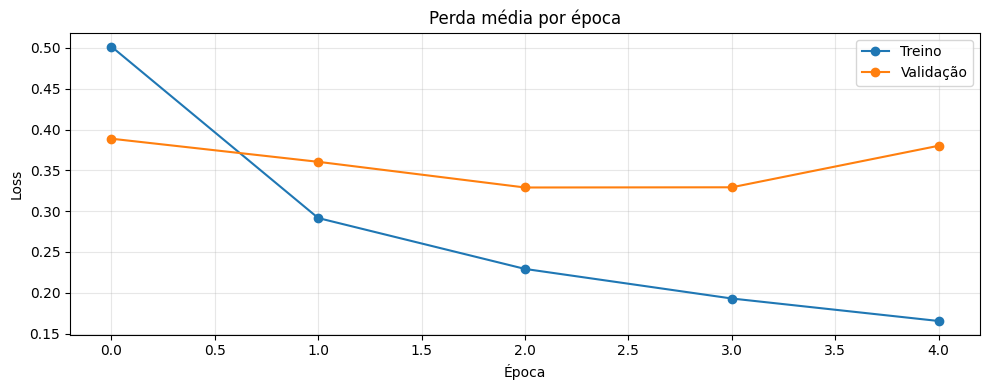

In [24]:
# Gráfico das perdas de treino e validação.
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.plot(train_losses, label='Treino', marker='o')
plt.plot(test_losses, label='Validação', marker='o')
plt.title('Perda média por época')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


In [25]:
# Salva o modelo fine-tunado derivado da VGG16_BN pré-treinada.
import datetime
from pathlib import Path
import torch

checkpoint_path = Path('vgg16_bn_pretrained_finetuned_v2.pt')
checkpoint = {
    'model_name': 'vgg16_bn_pretrained_finetuned_v2',
    'created_at': datetime.datetime.now().isoformat(),
    'state_dict': net.state_dict(),
    'class_to_idx': getattr(train_set, 'class_to_idx', None),
    'args': args,
}

torch.save(checkpoint, checkpoint_path)
print(f"Modelo salvo em {checkpoint_path.resolve()}")


Modelo salvo em /home/carloslessa@sefaz.al.gov.br/FCD/Alura/deep-learning-pytorch/rn-convolucionais/vgg16_bn_pretrained_finetuned_v2.pt


In [27]:
# Avaliação em uma amostra compartilhada entre os dois modelos.
import torch
from torch import nn
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms, models

subset_size = 256
generator = torch.Generator().manual_seed(42)
indices = torch.randperm(len(test_set), generator=generator)[:subset_size].tolist()

# Dataset e transform para o modelo treinado do zero (LeNet).
MEAN = (0.4914, 0.4822, 0.4465)
STD  = (0.2023, 0.1994, 0.2010)
scratch_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD),
])
scratch_subset = Subset(
    datasets.CIFAR10('.', train=False, transform=scratch_transform, download=False),
    indices
)
scratch_loader = DataLoader(scratch_subset, batch_size=64, shuffle=False)

# Dataset com pré-processamento do modelo pré-treinado (224px + ImageNet stats).
vgg_subset = Subset(
    datasets.CIFAR10('.', train=False, transform=data_transform, download=False),
    indices
)
vgg_loader = DataLoader(vgg_subset, batch_size=64, shuffle=False)

def build_lenet():
    return nn.Sequential(
        nn.Conv2d(3, 6, kernel_size=5, stride=1, padding=0),
        nn.BatchNorm2d(6),
        nn.Tanh(),
        nn.AvgPool2d(kernel_size=2, stride=2),
        nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0),
        nn.BatchNorm2d(16),
        nn.Tanh(),
        nn.AvgPool2d(kernel_size=2, stride=2),
        nn.Conv2d(16, 120, kernel_size=5, stride=1, padding=0),
        nn.BatchNorm2d(120),
        nn.Tanh(),
        nn.Flatten(),
        nn.Linear(120, 84),
        nn.Tanh(),
        nn.Linear(84, 10),
    )

# Carrega o modelo pré-treinado/fine-tunado.
ckpt_vgg = torch.load('vgg16_bn_pretrained_finetuned.pt', map_location='cpu')
vgg = models.vgg16_bn(weights=None)
in_features = vgg.classifier[-1].in_features
new_classifier = list(vgg.classifier.children())[:-1] + [nn.Linear(in_features, 10)]
vgg.classifier = nn.Sequential(*new_classifier)
vgg.load_state_dict(ckpt_vgg['state_dict'])
vgg.eval()

# Carrega o modelo pré-treinado/fine-tunado (v2).
ckpt_vgg_v2 = torch.load('vgg16_bn_pretrained_finetuned_v2.pt', map_location='cpu')
vgg_v2 = models.vgg16_bn(weights=None)
in_features = vgg_v2.classifier[-1].in_features
new_classifier = list(vgg_v2.classifier.children())[:-1] + [nn.Linear(in_features, 10)]
vgg_v2.classifier = nn.Sequential(*new_classifier)
vgg_v2.load_state_dict(ckpt_vgg_v2['state_dict'])
vgg_v2.eval()

def evaluate(model, loader):
    correct, total = 0, 0
    with torch.inference_mode():
        for images, targets in loader:
            outputs = model(images)
            preds = outputs.argmax(dim=1)
            correct += (preds == targets).sum().item()
            total += targets.size(0)
    return correct / max(1, total)

acc_vgg = evaluate(vgg, vgg_loader)
acc_vgg_v2 = evaluate(vgg_v2, vgg_loader)

print(f'VGG16 fine-tunada (pretrained): {acc_vgg*100:.2f}% em {subset_size} exemplos')
print(f'VGG16_v2 fine-tunada (pretrained): {acc_vgg_v2*100:.2f}% em {subset_size} exemplos')


VGG16 fine-tunada (pretrained): 90.23% em 256 exemplos
VGG16_v2 fine-tunada (pretrained): 89.45% em 256 exemplos
